In [16]:
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.models as models
import torch.optim as optim
import os
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchattacks
import matplotlib.pyplot as plt
import numpy as np
from models.mobilenetv3_small import MobileNetV3_small

In [17]:
model = MobileNetV3_small()
model.eval()

MobileNetV3_small(
  (mobilenet_v3_small): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
  

In [18]:
num_classes = 7
preprocessing = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

trash_test_dataset = torchvision.datasets.ImageFolder('./dataset/trashbox/test', transform=preprocessing)
trash_test_loader = torch.utils.data.DataLoader(dataset=trash_test_dataset, shuffle=False, batch_size=1)

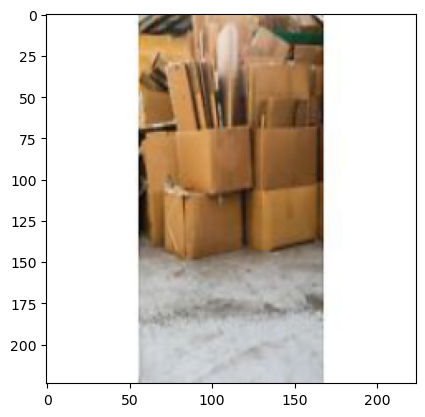

In [19]:
sample, _ = next(iter(trash_test_loader))

img  = sample[0].cpu().numpy()
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

In [20]:

output = model(sample)

_, predicted = output.max(1)

print(predicted)

torch.Size([1, 576, 1, 1])
tensor([2])


In [26]:
# # get the gradient of the output with respect to the parameters of the model
# predicted[:2].backward()

# pull the gradients out of the model
gradients = model.get_activations_gradient()

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
    
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

AttributeError: 'MobileNetV3_small' object has no attribute 'gradients'